We can load the hugging face gpt-2 model:

In [1]:
from transformers import GPT2LMHeadModel

Let's take a look at the parameters of the 124M parameter model.

This way, we can replicate their names and shapes into our model.

In [2]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2")

sd_hf = model_hf.state_dict()

for key, value in sd_hf.items():
    print(key, value.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

Generate some text:

In [7]:
from transformers import pipeline, set_seed
generator = pipeline("text-generation", model="gpt2")

set_seed(42)
generator("Hello, I'm a language model,", max_new_tokens=30, num_return_sequences=5)

Device set to use cpu
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "Hello, I'm a language model, I'm a language model. In my mind, I'm doing the same thing as you. All these different people are thinking about the same thing."},
 {'generated_text': 'Hello, I\'m a language model, and I\'m trying to understand what you\'re saying. In English, I have two English words: "l" and "es." In Dutch,'},
 {'generated_text': "Hello, I'm a language model, so I don't get much of a chance to interact with objects. But I did find that I can do things like check the state of a specific"},
 {'generated_text': 'Hello, I\'m a language model, a language model, a language model."'},
 {'generated_text': "Hello, I'm a language model, not a toolkit.\n\nIn a nutshell, I need to give language models a set of properties that I could use to describe them in real"}]

Lets use Tiny Shakespeare to take a look at how to create 
batches to feed into our model

In [9]:
with open("input.txt", "r") as f:
    text = f.read()

data = text[:1000]
print(data[:100])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


Tokenize the data:

In [10]:
import tiktoken
enc = tiktoken.get_encoding("gpt2")
tokens = enc.encode(data)
print(tokens[:24])

[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461, 11, 2740, 13]


But this is an 1D tensor, we want a (B, T) tensor to feed into the model.

In [11]:
import torch
buf = torch.tensor(tokens[:24 + 1])
x = buf[:-1].view(4, 6) # input
y = buf[1:].view(4, 6) # labels

print(f"x: {x}")
print(f"y: {y}")

for b in range(4):
  print(f"Batch: {b+1}")
  for t in range(6):
    print(f"When input is {x[b, :t+1].tolist()}, the label is {y[b, t]}")
  print()

x: tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])
y: tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]])
Batch: 1
When input is [5962], the label is 22307
When input is [5962, 22307], the label is 25
When input is [5962, 22307, 25], the label is 198
When input is [5962, 22307, 25, 198], the label is 8421
When input is [5962, 22307, 25, 198, 8421], the label is 356
When input is [5962, 22307, 25, 198, 8421, 356], the label is 5120

Batch: 2
When input is [5120], the label is 597
When input is [5120, 597], the label is 2252
When input is [5120, 597, 2252], the label is 11
When input is [5120, 597, 2252, 11], the label is 3285
When input is [5120, 597, 2252, 11, 3285], the la

Min Train Loss: 2.880896
Min Validation Loss: 3.0938
Max Hellaswag eval: 0.2616


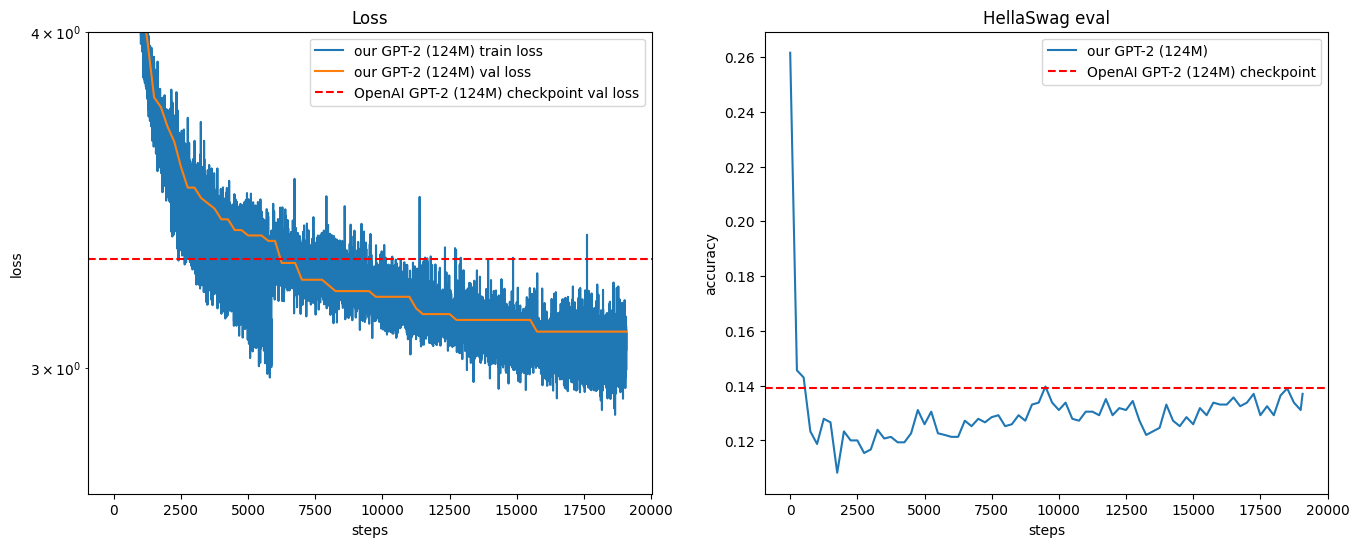

In [ ]:
# parse and visualize the logfile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sz = "124M"

loss_baseline = {
    "124M": 3.2924,
}[sz]
hella2_baseline = { # HellaSwag for GPT-2
    "124M": 0.1390,
    "350M": 0.375224,
    "774M": 0.431986,
    "1558M": 0.3469,
}[sz]


# load the log file
with open("log/log.txt", "r") as f:
    lines = f.readlines()

# parse the individual lines, group by stream (train,val,hella)
streams = {}
for line in lines:
    step, stream, val = line.strip().split()
    if stream not in streams:
        streams[stream] = {}
    streams[stream][int(step)] = float(val)

# convert each stream from {step: val} to (steps[], vals[])
# so it's easier for plotting
streams_xy = {}
for k, v in streams.items():
    # get all (step, val) items, sort them
    xy = sorted(list(v.items()))
    # unpack the list of tuples to tuple of lists
    streams_xy[k] = list(zip(*xy))

# create figure
plt.figure(figsize=(16, 6))

# Panel 1: losses: both train and val
plt.subplot(121)
xs, ys = streams_xy["train"] # training loss
ys = np.array(ys)
plt.plot(xs, ys, label=f'our GPT-2 ({sz}) train loss')
print("Min Train Loss:", min(ys))
xs, ys = streams_xy["val"] # validation loss
plt.plot(xs, ys, label=f'our GPT-2 ({sz}) val loss')
# horizontal line at GPT-2 baseline
if loss_baseline is not None:
    plt.axhline(y=loss_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint val loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.yscale('log')
plt.ylim(top=4.0)
plt.legend()
plt.title("Loss")
print("Min Validation Loss:", min(ys))

# Panel 2: HellaSwag eval
plt.subplot(122)
xs, ys = streams_xy["goldenswag"] # HellaSwag eval
ys = np.array(ys)
plt.plot(xs, ys, label=f"our GPT-2 ({sz})")
# horizontal line at GPT-2 baseline
if hella2_baseline:
    plt.axhline(y=hella2_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint")

plt.xlabel("steps")
plt.ylabel("accuracy")
plt.legend()
plt.title("HellaSwag eval")
print("Max Hellaswag eval:", max(ys))

## Model Architecture:

The GPT-2 (124M) parameter model has
- a maximum sequence length of 1024 tokens
- a vocabulary size of 50527 (total number of possible tokens)
- 12 transformer blocks
- 12 heads in multi-head attention
- 768 length embedding vector for each token.

### Embedding layers

- Word token embeddings (wte)
    - A lookup table for each token.
    - maps each token to its embedding, a vector of size n_embd (768).
    - Each embedding is a representation of its respective token that can be trained.
- Word positional embeddings (wpe)
    - Converts each token's positional index into a positional embedding. 
    - The wpe is trained to learn positional patterns that indices could not capture.


### Transformer Blocks

Each transformer block has
- Multi-head attention
- Multilayer perception (MLP)
- Layer Normalizations

#### Mutli-head attention

To talk about multihead attention, we first have to talk about attention layers.

Attention is a mechanism that allows the language model to weigh the relevance of other tokens to the token it is currently processing.
- Ex: prompt = "The quick brown fox jumps over the lazy dog". When processing "fox", the model pays more attention (haha get it?) to "quick" and "brown".
- When processing "dog", the model should care more about the token "lazy" than "fox". 
- For more information: https://arxiv.org/pdf/1706.03762

We perform attention with the Query, Key, and Value vectors. These vectors are computed by multiplying the input, which has shape B (num of sequences), T (sequence length in tokens), C (num_embd), by the query, key, and value weight matrices.

Note: B is just a batch dimension (it is the number of sequences), and it allows for the model to process multiple sequences in parallel. Thus, it doesn't affect the underlying math so we can drop it when explaining.

This essentially transforms the embedding for each token into three vectors of length num_embd; T, C -> T, 3C.
- Query (Q): What the token is looking for (search query)
- Key (K): What kind of information this token has to offer (labels like titles or tags)
- Value (V): The actual content you get (more on this soon)

For each token, its Q vector is multiplied with every other token's K vector.
- K has to be transposed from T, C to C, T so that we can do the dot product. (T, C) @ (C, T) -> (T, T).
- Think of the T x T matrix as the relevance we computed between each pair of tokens; how much attention each token should pay to every other token (attention score).
- The element at (i, j) in the T x T matrix is the dot product between the ith token's Q and the jth token's K.
- The math: $$\text{score}_{i,j} = Q_i \cdot K_j = \sum_{k=1}^{C} Q_{i,k}\ K_{j,k}$$

We then scale the attention matrix by $\frac{1}{\sqrt{C}}$ to prevent the dot product from growing too large.

We mask the relevance between tokens and future tokens (tokens later in the sequence) so that tokens can only pay attention to itself and previous tokens. This way, the model can't cheat by looking ahead at tokens it shouldn't know yet (we are trying to predict the next token!)

Since we have a T x T matrix, we use a triangular mask, which preserves only the lower triangle of the matrix; the elements in the upper triangle are set to -infinity.

We did -inf instead of something like 0 because we now apply the softmax function to each row to convert the attention scores for each token into weights that sum to 1. 

The softmax function is
$$\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^n e^{x_j}},$$
where $x_i$ is the ith element of the row we are applying softmax on. The denominator sums over all elements in the row, making the outputs in the row sum to 1.

Notice how if $x_i$ were -inf, softmax would output 0.

We compute the dot product between each row of the TxT matrix of attention weights and the value matrix (just the collection of each token's value vector) to get the weighted sum over all value vectors. (T, T) @ (T, C) -> (T, C)

Now, every token contributes to the new representation of each token, with some contributing more (higher attention weight), and some less (lower weight).

Complete math: $$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{Q K^T}{\sqrt{C}}\right) V $$


Multi-head attention is just having multiple attention "heads" doing these steps in parallel. Each head independently computes its own set of Q, K, V matrices, attention scores, and weighted sums.
- Each head focuses on different parts of each token's embedding. The dimension of each head (C) would be n_embd / num_heads instead of n_embd.
- The outputs of all heads are then concatenated back to the original embedding dimension.

Finally, this is passed into a linear projection, which mixes the outputs from the heads together (we only concatenated them before)


https://poloclub.github.io/transformer-explainer/ has a visual explanation.

#### MLP

The MLP is the multi-layer perception, which is just a feedforward neural network. It processes each token independently after we do attention.
- The first linear layer expands each token’s embedding from n_embd to 4*embd, which gives the model more dimensions for capturing complex patterns within the token.
- A GELU activation is applied to introduce nonlinearity, allowing the network to learn rich, nonlinear relationships. GELU is ReLU but smoother so that gradients flow better.
- GeLU v.s. ReLU:

<div style="margin-left: 40px;">
    <img src="images/ReLU_vs_GELU.png" 
         alt="GeLU vs ReLU" width="500">
</div>

- The second linear layer projects the token back to n_embd.

Attention gives each token's representation (embedding), information from every other token (weighted by attention ofc).Then, the MLP takes this enriched representation and crafts a deeper representation of each token.

#### Layer Normalization

Layer norms are in general just for stabilizing inputs/outputs and improving gradient flow; extreme values can destabilize training. They are typically applied after key steps.

Layer norms are applied before and after the attention step. They make sure that the inputs to the attention layer and the MLP have zero mean and unit variance.